In [1]:
#### Some problems
#### remove morph function from Network class to shift to hill climbing, also kernel_size and widening factor 
#### for deepen and widen should be parameters
### check more conformity betweeen input adj_list and input 'int_to_node'
### check compatibility of initial arch

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from graphviz import Digraph
import random
from IPython.display import IFrame

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
class Error(Exception):
    def __init__(self, expr = None, msg = None):
        self.expr = expr
        self.msg = msg
class inputSmallerThanKernel(Error):
    def __init__(self):
        super(inputSmallerThanKernel, self).__init__()
class nodeDoesNotExist(Error):
    def __init__(self):
        super(nodeDoesNotExist, self).__init__()

In [5]:
class node(object):
    nodes = []
    node_type = 'simple'
    def __init__(self, input_shape = (0, 0, 0), output_shape = (0, 0, 0)): # c, i1, i2
        node.nodes.append(self)
        self.no  = len(node.nodes)
        self.in_adj = []
        self.out_adj = []
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.compatible = True
            
    def node_alright(self, curr_node):
        try:
            assert(issubclass(type(curr_node), node))
        except:
            raise Error('Not a node' + str(type(curr_node)))
# Put this section in graph class
#         try:
#             assert(curr_node in graph_nodes)
#         except:
#             raise nodeDoesNotExist
    
    def determine_compatibility(self):
        for curr_node in self.in_adj:
            curr = (curr_node.output_shape == self.input_shape)
            self.compatible  = self.compatible and curr
            
        for curr_node in self.out_adj:
            curr = (curr_node.input_shape == self.output_shape)
            self.compatible = self.compatible and curr

    def describe_adj_list(self, in_adj, out_adj):
        assert isinstance(in_adj, list), 'in_adj must be a list'
        assert isinstance(in_adj, list), 'out_adj must be a list'
        for curr_node in in_adj + out_adj:
            try:
                self.node_alright(curr_node)
            except Exception as e:
                raise e
        self.in_adj = in_adj
        self.out_adj = out_adj

    def out_shape(self):
        pass
    
    def remove(self):
        ## needed in graph class
        pass
    
    
    def __str__(self):
        return str(self.no) + " " + str(node.node_type) 

    def __repr__(self):
        return self.__str__()

In [6]:
class convolution_block(nn.Module, node):
    all_convs = []
    node_type = 'conv'
    def __init__(self, in_h, in_w, in_channels, out_channels, kernel_size, padding = 0, stride = 1):
        try:
            assert(min(in_h, in_w) +2*padding >= kernel_size)
        except:
            raise inputSmallerThanKernel
        super(convolution_block, self).__init__()
        node.__init__(self, (in_channels, in_h, in_w))
        convolution_block.all_convs.append(self)
        self.in_channels  = in_channels
        self.out_channels = out_channels 
        self.kernel_size = kernel_size
        self.stride = stride 
        self.padding = padding
        self.output_shape = self.out_shape()
        
        # NN Layers
        self.conv_layer = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.batch_norm = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x

    def out_shape(self):
        c, h, w = self.input_shape
        C = self.out_channels
        H = (h + 2*self.padding - self.kernel_size)/self.stride + 1
        W = (w + 2*self.padding - self.kernel_size)/self.stride + 1
        return (C, H, W)
    
#     def determine_compatibility(self):
#         super(convolution_block, self).determine_compatibility()
#         self.compatible  = self.compatible and (len(self.in_adj) == 1)

    def describe_adj_list(self, in_adj, out_adj):
        super(convolution_block, self).describe_adj_list(in_adj, out_adj)
        try:
            assert(len(in_adj) == 1)
        except:
#             print(in_adj)
            raise Error('A convolution block can have only one in-edge')
    
    def remove(self): 
        ### Remove from all_convs list
        pass
    
    def __str__(self):
        return str(self.no) + " " + str(convolution_block.node_type) 
    
    def __repr__(self):
        return self.__str__()

In [7]:
class max_pool_node(nn.Module, node):
    all_max_pools = []
    node_type = 'max_pool'    
    def __init__(self, in_h, in_w, in_channels, kernel_size, padding = 0, stride = 1):
        try:
            assert(min(in_h, in_w) +2*padding > kernel_size)
        except:
            raise inputSmallerThanKernel
        super(max_pool_node, self).__init__()    
        node.__init__(self, (in_channels, in_h, in_w))
        max_pool_node.all_max_pools.append(self)
        self.kernel_size = kernel_size
        self.stride = stride 
        self.padding = padding
        self.output_shape = self.out_shape()
        
        ## NN Layer
        self.max_pool_layer = nn.MaxPool2d(self.kernel_size, self.stride, self.padding)
        
    def forward(self, x):
        return self.max_pool_layer(x)
    
    def out_shape(self):
        c, h, w = self.input_shape
        C = c
        H = (h + 2*self.padding - self.kernel_size)/self.stride + 1
        W = (w + 2*self.padding - self.kernel_size)/self.stride + 1
        return (C, H, W)
    
#     def determine_compatibility(self):
#         super(max_pool_node, self).determine_compatibility()
#         self.compatible  = self.compatible and (len(self.in_adj) == 1)

    def describe_adj_list(self, in_adj, out_adj):
        super(max_pool_node, self).describe_adj_list(in_adj, out_adj)
        try:
            assert(len(in_adj) == 1)
        except:
            raise Error('A max-pool block can have only one in-edge')

    def remove(self):
        pass
    
    def __str__(self):
        return str(self.no) + " " + str(max_pool_node.node_type) 
    
    def __repr__(self):
        return self.__str__()

In [8]:
### Is is it required to be to a derived class of nn.Module ?
class merge_node(node):
    all_merge_nodes = []
    node_type = 'merge'    
    def __init__(self, parents, child):
        super(merge_node, self).__init__()
#         node.__init__(self)
        try:
            self.describe_adj_list(parents, child)
        except Exception as e:
            print e.expr
            raise e
        merge_node.all_merge_nodes.append(self)
        
    def describe_adj_list(self, in_adj, out_adj):
        super(merge_node, self).describe_adj_list(in_adj, out_adj)
        try:
            assert(len(in_adj) == 2)
        except:
            raise Error('Parents must be exactly two')
        
class add_node(nn.Module, merge_node):
    all_add_nodes = []
    node_type = 'add'    
    def __init__(self, parents, child):
        super(add_node, self).__init__()
        merge_node.__init__(self, parents, child)
        add_node.all_add_nodes.append(self)
        self.input_shape = self.in_adj[0].output_shape
        self.output_shape = self.out_shape()
                
    ### Does it allow to input paramteters ?
    def forward(self, x, y):
        return x+y 
        
    def out_shape(self):
        return self.input_shape

    def __str__(self):
        return str(self.no) + " " + str(add_node.node_type) 
    
    def __repr__(self):
        return self.__str__()
    
class concat_node(merge_node):
    # Define Later
    pass

class convex_merge_node(merge_node):
    # Define Later
    pass

In [9]:
class fullyConnected(nn.Module,node) :
    def __init__(self, net) :   #nas
        super(fullyConnected,self).__init__()
        node.__init__(self, )
        self.net = net
        sh = net.int_to_node[net.topsort[-1]].output_shape
        out = sh[0]*sh[1]*sh[2]
#         out = nasout[1]*nasout[2]*nasout[3]
        self.fc1 = nn.Linear(out,16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16,10)
#         self.batch_size = nasout[0]
        
    def forward(self,x) :
        out = self.net(x)
#         out = out.view(self.batch_size,-1)
#         print(out.shape)
        out  =  out.view(out.shape[0], -1)
#         print 'out.shape', out.shape
#         [1 x 75264], m2: [2352 x 16]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

BATCH = 4
BEGIN_IN_CHANNELS = 3 
def addLinearLayers(net):
#     t = [32,3,28,28]
    net = fullyConnected(net)
    return net


In [10]:
class Network(nn.Module, object):
    def __init__(self):
        super(Network, self).__init__()
        self.adj_mat = {}
        self.adj_list = {}
        self.nodes = []
        self.int_to_node = {}
        self.node_to_int = {}
        self.conv_blocks = []
        self.max_pool_blocks = [] # Change naming conv maybe ?
        self.topsort = []
        self.rank_in_topsort = {}
        self.max_no = 0
        self.node_dict = {}
        
        #self.fc = nn.Linear(3 * 28 * 28, 10)
        
    def __init__(self, adj_list, int_to_node):
        super(Network, self).__init__()
        assert isinstance(int_to_node, dict), 'int_to_node must be a dictionary'
        for _, cnode in int_to_node.items():
            assert isinstance(cnode, node), 'mapping in int_to_node should be to a node'
        
        assert isinstance(adj_list, dict), 'adj_list should be a dictionary'
        assert(len(int_to_node) == len(adj_list))
        for cnode, li in adj_list.items():
            assert cnode in int_to_node, 'mismatch between int_to_node and adj_list'
            try:
                assert(isinstance(li, list))
                assert(len(li) == 2)
                assert(isinstance(li[0], list) and isinstance(li[1], list))
            except:
                raise Error('Each mapping in adj_list should be to a two-dim list')
            for child_node in li[0]:
                assert child_node in int_to_node, 'mismatch between int_to_node and adj_list'
            for child_node in li[1]:
                assert child_node in int_to_node, 'mismatch between int_to_node and adj_list'

        self.adj_list = adj_list
        self.adj_mat = self.get_adj_mat(self.adj_list)
        self.nodes = int_to_node.keys()
        self.int_to_node = int_to_node
        self.node_dict = {}
        self.node_to_int = self.get_node_to_int(self.int_to_node)
        self.max_no = max(self.int_to_node)
        self.conv_blocks, self.max_pool_blocks = self.get_conv_and_max_pool_blocks()
        self.topsort = []
        self.rank_in_topsort = {}
        self.topsorting()
        # hardcoded part
        #self.fc = torch.nn.Linear(3 * 28 * 28, 10)
        
        
    def createModel(self):
         self.node_dict = torch.nn.ModuleDict(self.node_dict)
         #print(self.node_dict)
        
    def forward(self, x):
        self.topsorting() # though this is not required here
        outputs = {}
#         outputs[self.topsort[0]] = self.int_to_node[self.topsort[0]].forward(x)
#       This is a bit inconsistent with the design patt
        
       # print 'self.topsort ',self.topsort
        
        outputs[self.topsort[0]] = x # instead add identity forward function to node class for dummy object
        for ind in range(1, len(self.topsort)):
            node_no = self.topsort[ind]
            curr_node = self.int_to_node[node_no]
            outputs[node_no] = curr_node.forward(*map(lambda x: outputs[x], self.adj_list[node_no][0]))
        return outputs[self.topsort[-1]]
    
    def get_node_to_int(self, int_to_node):
        node_to_int = {}
        for no, cnode in int_to_node.items():
            node_to_int[cnode] = no
        return node_to_int

        
    def get_adj_mat(self, adj_list):
        adj_mat = {}
        nodes = adj_list.keys()
        for x in nodes:
            adj_mat[x] = {}
            for y in nodes:
                adj_mat[x][y] = 0
        for cnode, li in adj_list.items():
            for par in li[0]:
                adj_mat[par][cnode] = 1
            for child in li[1]:
                adj_mat[cnode][child] = 1
        return adj_mat
    
    def get_conv_and_max_pool_blocks(self):
        conv_blocks = []
        max_pool_blocks = []
        for x in self.nodes:
            if isinstance(self.int_to_node[x], convolution_block):
                conv_blocks.append(x)
                self.node_dict[str(x)]=self.int_to_node[x]
            elif isinstance(self.int_to_node[x], max_pool_node):
                max_pool_blocks.append(x)
                self.node_dict[str(x)]=self.int_to_node[x]
        return (conv_blocks, max_pool_blocks)
    
    def topsorting(self):
        # level problem
        topsort = []
        import Queue
        in_deg = {}
        q = Queue.Queue()
        for node in self.nodes:
            val  = len(self.adj_list[node][0])
#             val = len(self.int_to_node[node].in_adj)
            if val == 0:
                q.put(node)
            in_deg[node] = val
            
        while not q.empty():
            curr_node = q.get()
            topsort.append(curr_node)
            for child in self.adj_list[curr_node][1]:
                in_deg[child] -= 1
                if in_deg[child] == 0:
                    q.put(child)
        self.topsort = topsort
        self.set_rank_in_topsort()
    
    def set_rank_in_topsort(self):
        for ind, node_no in enumerate(self.topsort):
            self.rank_in_topsort[node_no]  = ind
    
    def add_nodes_to_network(self, nodes):
        ### loophole here, assumption is that all changed nodes are being provided to the function
        ### for now, lets go on with it, but its an issue
        for curr_node in nodes:
            curr_node.determine_compatibility()
            if not curr_node.compatible:
                raise Error('Node is not compatible with the graph') 
        for curr_node in nodes:
            if curr_node not in self.node_to_int:
                self.max_no += 1
                self.adj_mat[self.max_no] = {}
                self.adj_list[self.max_no] = [[], []]
                self.node_to_int[curr_node] = self.max_no
                self.int_to_node[self.max_no] = curr_node
                self.nodes.append(self.max_no)
                if isinstance(curr_node, convolution_block):
                    self.conv_blocks.append(self.max_no)
                    self.node_dict[str(self.max_no)]=curr_node
                    
                elif isinstance(curr_node, max_pool_node):
                    self.max_pool_blocks.append(self.max_no)
                    self.node_dict[str(self.max_no)]=curr_node
        for curr_node in nodes:
            no = self.node_to_int[curr_node]
            try:
                self.adj_list[no] = [map(lambda x: self.node_to_int[x], curr_node.in_adj), map(lambda x: self.node_to_int[x], curr_node.out_adj)]
            except:
#                 print self.node_to_int
#                 print curr_node.in_adj
#                 print curr_node.out_adj
                raise Exception
            for par in self.adj_list[no][0]:
                self.adj_mat[par][no] = 1
            for child in self.adj_list[no][0]:
                self.adj_mat[no][child] = 1
        self.topsorting()
            
    def deepen_morph(self):
        deepen_conv_block = self.int_to_node[random.choice(self.conv_blocks)]
        kernel_size = random.choice([3, 5])
        in_channels, in_h, in_w = deepen_conv_block.output_shape
        out_channels = in_channels
        identity_conv_block = convolution_block(in_h, in_w, in_channels, out_channels, kernel_size, (kernel_size-1)/2)
        weights = identity_conv_block.conv_layer.weight.data
        
        # creating identity weights
        for channel in range(out_channels):
            for i in range(in_channels):
                for j in range(kernel_size):
                    for k in range(kernel_size):
                        weights[channel][i][j][k] = int((channel == i) and (j == k) and j == (kernel_size)/2 )
#         print 'weights of identity conv block', weights
        
        ## make connections 
        identity_conv_block.describe_adj_list([deepen_conv_block], deepen_conv_block.out_adj)
        deepen_conv_block.describe_adj_list(deepen_conv_block.in_adj, [identity_conv_block])

        #### later look at creating a function for singular change to in_adj or out_adj of nodes
        for out_node in identity_conv_block.out_adj:
            out_node_in_adj = [identity_conv_block if (x == deepen_conv_block) else x for x in out_node.in_adj ]
            out_node.describe_adj_list(out_node_in_adj, out_node.out_adj)
        
        self.add_nodes_to_network([deepen_conv_block, identity_conv_block] + identity_conv_block.out_adj)
    
    
    def widen_morph(self):
        candidate_conv_blocks = []
        for conv_block in self.conv_blocks:
            isCandidate = bool(len(self.adj_list[conv_block][1]))
            for child in self.adj_list[conv_block][1]:
                isCandidate = isCandidate and isinstance(self.int_to_node[child], convolution_block)
            if isCandidate:
                candidate_conv_blocks.append(conv_block)
        if len(candidate_conv_blocks) == 0:
            return False

        parent_block_no = random.choice(candidate_conv_blocks)
        parent_block = self.int_to_node[parent_block_no]
        widening_factor = random.choice([2, 4])
        in_channels, in_h, in_w = parent_block.input_shape
        out_channels = parent_block.out_channels
        kernel_size = parent_block.kernel_size
        padding = parent_block.padding
        stride = parent_block.stride
        widened_parent_block = convolution_block(in_h, in_w, in_channels, out_channels*widening_factor, kernel_size, padding, stride)
        original_parent_weight = parent_block.conv_layer.weight.data
        widened_parent_weight = widened_parent_block.conv_layer.weight.data
        widened_parent_weight[:out_channels] = original_parent_weight
        widened_parent_weight[out_channels:] = torch.zeros((out_channels*(widening_factor-1), in_channels, kernel_size, kernel_size))
        parent_block = widened_parent_block
#         self.int_to_node[parent_block_no]  = widened_parent_block
#         del self.node_to_int[parent_block]
#         self.node_to_int[widened_parent_block] = parent_block_no
        parent_out_adj = []
        for child in parent_block.out_adj:
            child_no = self.node_to_int[child]
            in_channels, in_h, in_w = child.input_shape
            out_channels = child.out_channels
            kernel_size = child.kernel_size 
            padding = child.padding
            stride = child.stride
            child_widened = convolution_block(in_h, in_w, in_channels*widening_factor, out_channels, kernel_size, padding, stride)
            child_widened.conv_layer.weight.data[:, :in_channels, :, :] = child.conv_layer.weight.data
#             child_widened.describe_adj_list([widened_parent_block if x == parent_block else x for x in child.in_adj], child.out_adj)
#             self.int_to_node[child_no] = child_widened
#             del self.node_to_int[child]
#             self.node_to_int[child_widened] = child_no
#             parent_out_adj.append(child_widened)
#         widened_parent_block.describe_adj_list(parent_block.in_adj, parent_out_adj)
    
    def dfs(self, curr_node, visited, weight):
        visited[curr_node] = weight
        for child in self.adj_list[curr_node][1]:
            if child not in visited:
                kernel = 0
                padding = 0
                constant = 0
                child_node = self.int_to_node[child]
                ## make adjustments for concatenation
                if isinstance(child_node, convolution_block) or isinstance(child_node, max_pool_node):
                    kernel = child_node.kernel_size
                    padding = child_node.padding
                    constant = 1
                self.dfs(child, visited, [weight[0]+kernel, weight[1]+padding, weight[2]+constant])
        
        
    def get_descendant_vectors(self):
        descs = {}
        for curr_node in self.nodes:
            visited = {}
            self.dfs(curr_node, visited, [0, 0, 0])
            del visited[curr_node] # remove root 
            descs[curr_node] = visited
        return descs
        
    def skip_morph(self):
        descs = self.get_descendant_vectors()
        candidates = [(ans, des) for ans in descs for des in descs[ans] ]
        no1, no2 = random.choice(candidates)
        weight = descs[no1][no2]
        #join outputs of node1 and node2 using a merge block
        node_a = self.int_to_node[no1]
        node_b = self.int_to_node[no2]
        out_ch_1, out_h_1, out_w_1 = node_a.output_shape
        out_ch_2, out_h_2, out_w_2 = node_b.output_shape
#         print 'selected_nodes are ', no1, "  ",no2
#         print 'weight is   ', weight
#         print(out_h_1, out_h_2, weight[0] - 2*weight[1] - weight[2])
        assert(out_h_1 - out_h_2 == out_w_1 - out_w_2)
        assert(out_h_1 - out_h_2 == weight[0] - 2*weight[1] - weight[2])

        if weight[2] & 1 == 0:
            weight[2] += 1
            weight[0] += 1
        weight[1] += (weight[2])/2
        weight[2] -= 2*(weight[2]/2)
        kernel_size = weight[0]
        padding = weight[1]
        stride = 1
        new_conv = convolution_block(out_h_1, out_w_1, out_ch_1, out_ch_2, kernel_size, padding, stride)
        new_add = add_node([new_conv, node_b], node_b.out_adj)
        new_conv.describe_adj_list([node_a], [new_add])
        new_conv.conv_layer.weight.data = torch.zeros(new_conv.conv_layer.weight.data.shape)
        node_a.describe_adj_list(node_a.in_adj, node_a.out_adj+[new_conv])
        for child_node in node_b.out_adj:
            child_node.describe_adj_list([new_add if x==node_b else x for x in child_node.in_adj], child_node.out_adj)
        node_b.describe_adj_list(node_b.in_adj, [new_add])
        self.add_nodes_to_network([node_a, node_b, new_conv, new_add] + new_add.out_adj)
        
        
        ###
    
    def visualize(self):
        graph = Digraph('./images/arch', './images/arch.gv')
        for no, curr_node in self.int_to_node.items():
#             graph.node(str(no), str(type(curr_node)).split('__main__.')[1])
            graph.node(str(no), str(self.node_to_int[curr_node]) + " :: " + repr(curr_node)[:200])
        for no, li in self.adj_list.items():
            for ch in li[1]:
                graph.edge(str(no), str(ch))
        graph.view()
#         x = IFrame("./images/archgv.pdf", width=600, height=300)
#         print x
    
    def describe(self):
        print 'Nodes: ', self.nodes
        print 'Conv_blocks', self.conv_blocks
        print 'Max_pool_blocks', self.max_pool_blocks
        print 'Adj_list', self.adj_list
        print 'Adj_mat', self.adj_mat
        print 'int_to_node', self.int_to_node
        print 'node_to_int', self.node_to_int
        print 'Toposort', self.topsort
        print 'node_dict', self.node_dict
    

In [11]:
def test():    
    dummy = node((3, 32, 32), (3, 32, 32))
    #     input_shape = (0, 0, 0), output_shape = (0, 0, 0)): # c, i1, i2
    n1 = convolution_block(32, 32, 3, 4, 3)
    #     in_h, in_w, in_channels, out_channels, kernel_size, padding = 0, stride = 1)
    n2 = convolution_block(30, 30, 4, 3, 3)
    dummy.describe_adj_list([], [n1])
    n1.describe_adj_list([dummy], [n2])
    n2.describe_adj_list([n1], [])
    
    
    net = Network({0:[[], [1]], 1:[[0], [2]], 2: [[1], []]}, {0: dummy, 1:n1, 2:n2})
    net.describe() 
    net.visualize()
    for nan in net.nodes:
        print net.int_to_node[nan].input_shape, ' -> ', nan, '->', net.int_to_node[nan].output_shape 
    for i in range(20):
        print "Iteration", i
        net.skip_morph()
        net.deepen_morph()
        net.widen_morph()
        net.visualize()
    net=addLinearLayers(net)


In [12]:
test()

Nodes:  [0, 1, 2]
Conv_blocks [1, 2]
Max_pool_blocks []
Adj_list {0: [[], [1]], 1: [[0], [2]], 2: [[1], []]}
Adj_mat {0: {0: 0, 1: 1, 2: 0}, 1: {0: 0, 1: 0, 2: 1}, 2: {0: 0, 1: 0, 2: 0}}
int_to_node {0: 1 simple, 1: 2 conv, 2: 3 conv}
node_to_int {1 simple: 0, 3 conv: 2, 2 conv: 1}
Toposort [0, 1, 2]
node_dict {'1': 2 conv, '2': 3 conv}
(3, 32, 32)  ->  0 -> (3, 32, 32)
(3, 32, 32)  ->  1 -> (4, 30, 30)
(4, 30, 30)  ->  2 -> (3, 28, 28)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19


In [71]:
### Training Part

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [15]:
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    return(train_loader)

#Test and validation loaders have constant batch sizes, so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

In [16]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [17]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #for accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()  
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s Training Accuracy: {:.2f} ".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time, 100.*correct/total))
                
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        val_total = 0
        val_correct = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
            
            #for val acc
            _, predicted = val_outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()  
            
        print "Validation Acc", 100*val_correct/val_total      
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))


In [18]:
def dummy_train():    
    dummy = node((3, 32, 32), (3, 32, 32))
#     input_shape = (0, 0, 0), output_shape = (0, 0, 0)): # c, i1, i2
    n1 = convolution_block(32, 32, 3, 18, 3)
#     in_h, in_w, in_channels, out_channels, kernel_size, padding = 0, stride = 1)
    p = max_pool_node(30, 30, 18, 2)
    n2 = convolution_block(29, 29, 18, 3, 3)
    dummy.describe_adj_list([], [n1])
    n1.describe_adj_list([dummy], [p])
    p.describe_adj_list([n1], [n2])
    n2.describe_adj_list([p], [])
    net = Network({0:[[], [1]], 1:[[0], [2]], 2: [[1], [3]], 3:[[2], []]}, {0: dummy, 1:n1, 2: p, 3:n2})
    net.createModel()
#     net.describe()                    
#     net.visualize()
#     print (net.int_to_node[net.topsort[-1]].out_shape())
    net=addLinearLayers(net)
#     print list(n1.parameters())
#     for nan in net.nodes:
#         print net.int_to_node[nan].input_shape, ' -> ', nan, '->', net.int_to_node[nan].output_shape 
#     for i in range(20):
#         net.skip_morph()
#         net.deepen_morph()
#         net.widen_morph()
#     net.visualize()
#     print list(net.parameters())
#     print issubclass(type(net), nn.Module)
    trainNet(net, batch_size=32, n_epochs=30, learning_rate=0.0001)

In [19]:
dummy_train()


===== HYPERPARAMETERS =====
('batch_size=', 32)
('epochs=', 30)
('learning_rate=', 0.0001)


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 2.33 took: 3.16s Training Accuracy: 10.62 
Epoch 1, 20% 	 train_loss: 2.30 took: 2.78s Training Accuracy: 10.71 
Epoch 1, 30% 	 train_loss: 2.23 took: 2.77s Training Accuracy: 11.03 
Epoch 1, 40% 	 train_loss: 2.17 took: 3.37s Training Accuracy: 12.52 
Epoch 1, 50% 	 train_loss: 2.09 took: 4.36s Training Accuracy: 14.16 
Epoch 1, 60% 	 train_loss: 2.08 took: 2.93s Training Accuracy: 15.65 
Epoch 1, 70% 	 train_loss: 2.05 took: 2.80s Training Accuracy: 16.91 
Epoch 1, 80% 	 train_loss: 2.01 took: 2.90s Training Accuracy: 18.20 
Epoch 1, 90% 	 train_loss: 1.97 took: 2.99s Training Accuracy: 19.50 


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:78: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Acc 32
Validation loss = 1.87
Epoch 2, 10% 	 train_loss: 1.91 took: 2.92s Training Accuracy: 32.79 
Epoch 2, 20% 	 train_loss: 1.89 took: 2.84s Training Accuracy: 33.63 
Epoch 2, 30% 	 train_loss: 1.87 took: 2.85s Training Accuracy: 34.26 
Epoch 2, 40% 	 train_loss: 1.84 took: 2.85s Training Accuracy: 34.62 
Epoch 2, 50% 	 train_loss: 1.81 took: 2.83s Training Accuracy: 35.04 
Epoch 2, 60% 	 train_loss: 1.79 took: 2.82s Training Accuracy: 35.36 
Epoch 2, 70% 	 train_loss: 1.74 took: 2.84s Training Accuracy: 35.92 
Epoch 2, 80% 	 train_loss: 1.73 took: 2.88s Training Accuracy: 36.30 
Epoch 2, 90% 	 train_loss: 1.72 took: 2.85s Training Accuracy: 36.62 
Validation Acc 41
Validation loss = 1.64
Epoch 3, 10% 	 train_loss: 1.68 took: 2.95s Training Accuracy: 40.13 
Epoch 3, 20% 	 train_loss: 1.68 took: 2.84s Training Accuracy: 41.10 
Epoch 3, 30% 	 train_loss: 1.62 took: 2.81s Training Accuracy: 41.87 
Epoch 3, 40% 	 train_loss: 1.60 took: 2.86s Training Accuracy: 42.50 
Epoch 3,

Epoch 14, 20% 	 train_loss: 1.35 took: 2.88s Training Accuracy: 51.76 
Epoch 14, 30% 	 train_loss: 1.32 took: 2.86s Training Accuracy: 52.33 
Epoch 14, 40% 	 train_loss: 1.31 took: 2.83s Training Accuracy: 52.65 
Epoch 14, 50% 	 train_loss: 1.33 took: 2.88s Training Accuracy: 52.72 
Epoch 14, 60% 	 train_loss: 1.35 took: 2.86s Training Accuracy: 52.65 
Epoch 14, 70% 	 train_loss: 1.33 took: 2.87s Training Accuracy: 52.95 
Epoch 14, 80% 	 train_loss: 1.36 took: 2.86s Training Accuracy: 52.75 
Epoch 14, 90% 	 train_loss: 1.34 took: 2.86s Training Accuracy: 52.99 
Validation Acc 50
Validation loss = 1.38
Epoch 15, 10% 	 train_loss: 1.29 took: 2.99s Training Accuracy: 55.31 
Epoch 15, 20% 	 train_loss: 1.34 took: 2.89s Training Accuracy: 53.55 
Epoch 15, 30% 	 train_loss: 1.35 took: 2.86s Training Accuracy: 53.54 
Epoch 15, 40% 	 train_loss: 1.34 took: 2.86s Training Accuracy: 53.39 
Epoch 15, 50% 	 train_loss: 1.30 took: 2.88s Training Accuracy: 53.51 
Epoch 15, 60% 	 train_loss: 1.30 too

Epoch 26, 30% 	 train_loss: 1.19 took: 3.15s Training Accuracy: 58.32 
Epoch 26, 40% 	 train_loss: 1.20 took: 3.11s Training Accuracy: 58.59 
Epoch 26, 50% 	 train_loss: 1.25 took: 2.86s Training Accuracy: 57.73 
Epoch 26, 60% 	 train_loss: 1.18 took: 3.03s Training Accuracy: 57.87 
Epoch 26, 70% 	 train_loss: 1.24 took: 3.04s Training Accuracy: 57.82 
Epoch 26, 80% 	 train_loss: 1.19 took: 2.93s Training Accuracy: 57.84 
Epoch 26, 90% 	 train_loss: 1.22 took: 3.08s Training Accuracy: 57.77 
Validation Acc 50
Validation loss = 1.36
Epoch 27, 10% 	 train_loss: 1.19 took: 2.94s Training Accuracy: 58.04 
Epoch 27, 20% 	 train_loss: 1.18 took: 2.87s Training Accuracy: 58.43 
Epoch 27, 30% 	 train_loss: 1.18 took: 2.85s Training Accuracy: 58.32 
Epoch 27, 40% 	 train_loss: 1.22 took: 2.92s Training Accuracy: 57.95 
Epoch 27, 50% 	 train_loss: 1.24 took: 2.87s Training Accuracy: 57.70 
Epoch 27, 60% 	 train_loss: 1.22 took: 2.82s Training Accuracy: 57.83 
Epoch 27, 70% 	 train_loss: 1.19 too

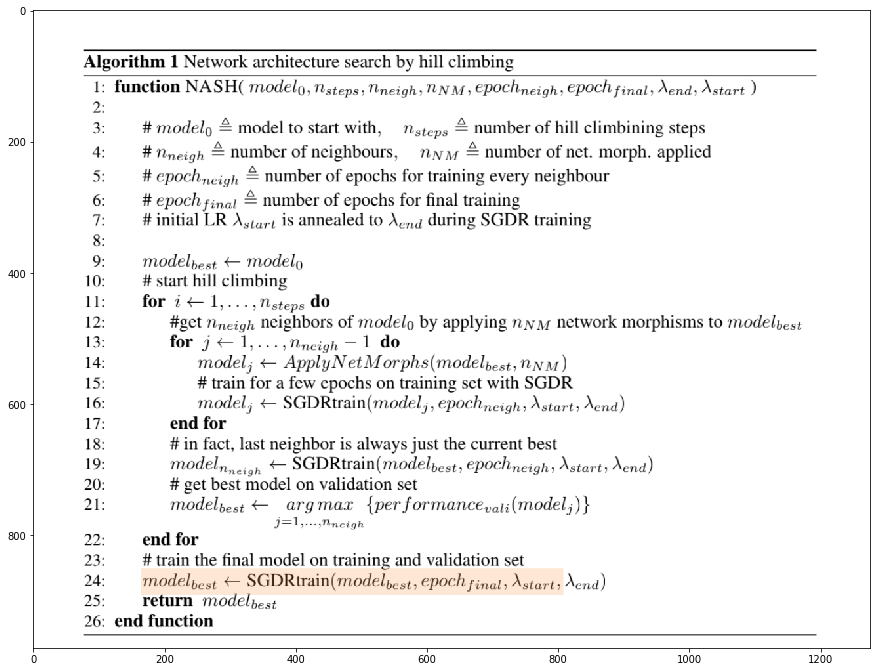

In [124]:
import cv2
x  = cv2.imread('./images/hill_climb.png')
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15))
plt.imshow(x)

In [ ]:
def hill_climbing(n_steps  = 5, n_neigh = 5, nNM = 5, epoch_neigh = 17, epoch_final = 100, l_start = 0.05, l_end = 0, init_net_func):
    total_instances = n_steps * n_neigh
    instances = [None for i in range(tot)]
    for i in range(n_neigh):
        instancec[i] = init_net_func()
    morphisms = ['deepen', 'widen', 'skip']
    for iter in range(iterations):
        operations = []
        for op in range(br_factor):
            curr_op = random.choice(morphisms)
            operations.append(curr_op)
            if curr_op == 'deepen':
                instances[iter*br_factor+op].deepen_morph
            elif curr_op == 'widen':
                pass
            else:
                pass
        

In [120]:
! ls images/hill_climb.png

images/hill_climb.png
